In [14]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
import math
import random
from icecream import ic
import matplotlib.pyplot as plt
import functools
logging.basicConfig(level=logging.DEBUG)

In [15]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()
len(CITIES)

46

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [16]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

In [17]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp = list()
tsp.append(int(city))
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    logging.debug(
        f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
    )
    visited[closest] = True
    city = closest
    tsp.append(int(city))
logging.debug(
    f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
)
tsp.append(tsp[0])


logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")

DEBUG:root:step: Ancona -> Rimini (90.60km)
DEBUG:root:step: Rimini -> Forlì (46.72km)
DEBUG:root:step: Forlì -> Ravenna (26.46km)
DEBUG:root:step: Ravenna -> Ferrara (66.67km)
DEBUG:root:step: Ferrara -> Bologna (43.43km)
DEBUG:root:step: Bologna -> Modena (37.29km)
DEBUG:root:step: Modena -> Reggio nell'Emilia (23.94km)
DEBUG:root:step: Reggio nell'Emilia -> Parma (26.94km)
DEBUG:root:step: Parma -> Piacenza (57.65km)
DEBUG:root:step: Piacenza -> Milan (60.65km)
DEBUG:root:step: Milan -> Monza (14.51km)
DEBUG:root:step: Monza -> Bergamo (33.92km)
DEBUG:root:step: Bergamo -> Brescia (46.02km)
DEBUG:root:step: Brescia -> Verona (61.42km)
DEBUG:root:step: Verona -> Vicenza (44.70km)
DEBUG:root:step: Vicenza -> Padua (30.13km)
DEBUG:root:step: Padua -> Venice (36.07km)
DEBUG:root:step: Venice -> Trieste (115.09km)
DEBUG:root:step: Trieste -> Bolzano (209.68km)
DEBUG:root:step: Bolzano -> Trento (49.94km)
DEBUG:root:step: Trento -> Novara (206.69km)
DEBUG:root:step: Novara -> Turin (84.46

# Fast solution 
Greedy initialized with simmulate annealing  for a fast approximate solution for the TSP problem.

In [18]:


# Define the 2-opt swap function
def two_opt_swap(tour, i, j):
    """Perform a 2-opt swap by reversing the order of cities between indices i and j."""
    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    return new_tour

# Define scalable Simulated Annealing function
def scalable_simulated_annealing(initial_solution, dist_matrix, num_cities):
    # Set parameters based on the size of the dataset
     # Set adaptive parameters based on the dataset size
    initial_temp = 1  # Scales with the number of cities
    cooling_rate = 0.999  # Slow cooling for large instances
    min_temp = 1e-5  # Minimum temperature
    max_iter_per_temp =max(5,num_cities//70)  # Iterations per temperature level
    max_no_improvement = 100  # Stop if no improvement for 10 consecutive iterations
    
    current_solution = initial_solution
    current_cost = tsp_cost(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    temperature = initial_temp
    steps=0
    iteration = 0
    no_improvement_count = 0

    while temperature > min_temp and no_improvement_count < max_no_improvement:

        # Perform a fixed number of iterations per temperature level to scale to larger datasets
        for _ in range(max_iter_per_temp):
            # Generate a neighbor by performing a 2-opt swap
            i, j = sorted(random.sample(range(1, len(current_solution) - 1), 2))
            new_solution = two_opt_swap(current_solution, i, j)
            steps+=1
            new_cost = tsp_cost(new_solution)
            
            # Calculate the cost difference
            delta_cost = new_cost - current_cost

            # Decide whether to accept the new solution
            if delta_cost < 0 or random.random() < math.exp(-delta_cost / temperature):
                current_solution = new_solution
                current_cost = new_cost

                # Update the best solution if the new solution is better
                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1    

        # Cool down the temperature
        temperature *= cooling_rate
        iteration += 1

        # Logging progress every few iterations
        if iteration % 100 == 0 or temperature <= min_temp:
            print(f"Iteration {iteration}: Current best cost = {best_cost:.2f}, Temperature = {temperature:.2f}")

    return best_solution, best_cost,steps

# Example usage with initial greedy solution `tsp` and distance matrix `DIST_MATRIX`
num_cities = len(DIST_MATRIX)  # Number of cities in the dataset

# Run Simulated Annealing with dynamic scaling
refined_solution, refined_cost ,steps = scalable_simulated_annealing(tsp, DIST_MATRIX, num_cities)

# Display the results
print("Initial Greedy Solution Cost:", tsp_cost(tsp))
print("Refined Solution from Scalable Simulated Annealing:", refined_solution)
print("Refined Cost from Scalable Simulated Annealing:", refined_cost)
print("Steps:", steps)


Iteration 100: Current best cost = 4377.59, Temperature = 0.90
Iteration 200: Current best cost = 4377.59, Temperature = 0.82
Iteration 300: Current best cost = 4342.26, Temperature = 0.74
Iteration 400: Current best cost = 4336.57, Temperature = 0.67
Iteration 500: Current best cost = 4336.57, Temperature = 0.61
Iteration 600: Current best cost = 4294.11, Temperature = 0.55
Iteration 700: Current best cost = 4294.11, Temperature = 0.50
Iteration 800: Current best cost = 4294.11, Temperature = 0.45
Iteration 900: Current best cost = 4294.11, Temperature = 0.41
Iteration 1000: Current best cost = 4294.11, Temperature = 0.37
Iteration 1100: Current best cost = 4294.11, Temperature = 0.33
Iteration 1200: Current best cost = 4294.11, Temperature = 0.30
Iteration 1300: Current best cost = 4294.11, Temperature = 0.27
Iteration 1400: Current best cost = 4294.11, Temperature = 0.25
Iteration 1500: Current best cost = 4294.11, Temperature = 0.22
Iteration 1600: Current best cost = 4294.11, Temp

Generation 0: Best tour length = 4436.03 km
Generation 10: Best tour length = 4172.76 km
Generation 20: Best tour length = 4172.76 km
Generation 30: Best tour length = 4172.76 km
Generation 40: Best tour length = 4172.76 km
Restarting at generation 48 due to lack of improvement.
Generation 50: Best tour length = 4172.76 km
Generation 60: Best tour length = 4172.76 km
Generation 70: Best tour length = 4172.76 km
Generation 80: Best tour length = 4172.76 km
Restarting at generation 88 due to lack of improvement.
Generation 90: Best tour length = 4172.76 km
Generation 100: Best tour length = 4172.76 km
Generation 110: Best tour length = 4172.76 km
Generation 120: Best tour length = 4172.76 km
Restarting at generation 128 due to lack of improvement.
Generation 130: Best tour length = 4172.76 km
Generation 140: Best tour length = 4172.76 km
Best tour found: [7, 24, 8, 37, 31, 17, 38, 2, 1, 11, 35, 21, 14, 15, 34, 39, 26, 27, 0, 33, 12, 30, 9, 23, 43, 41, 5, 40, 45, 44, 6, 3, 20, 18, 22, 42,

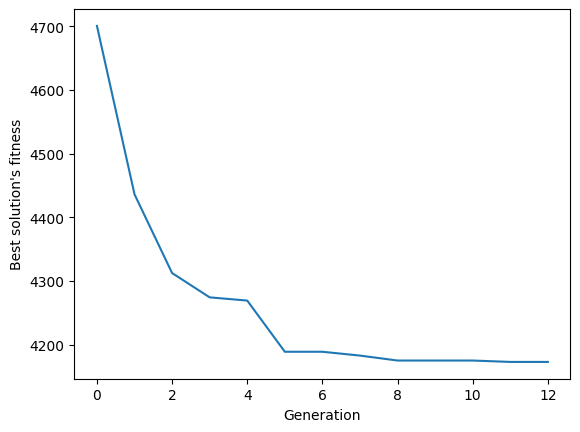

In [25]:

# Fitness function (inverse of distance)
@counter
def fitness(tour):
    return 1 / tsp_cost(tour)  # Higher fitness for shorter tours

def greedy(start_city):
    num_cities = len(DIST_MATRIX)
    unvisited = set(range(num_cities))
    unvisited.remove(start_city)
    tour = [start_city]
    current_city = start_city

    while unvisited:
        next_city = min(unvisited, key=lambda city: DIST_MATRIX[current_city][city])
        tour.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city

    tour.append(start_city)  # Return to start to complete the tour
    return tour

# Limited Greedy and Random Initialization for High Diversity
def initialize_population_with_diversity(pop_size, greedy_percentage=0.05):
    population = []
    num_greedy = int(pop_size * greedy_percentage)
 

    # Generate a small portion of the population using greedy
    for _ in range(num_greedy):
        start_city = random.randint(0, len(DIST_MATRIX) - 1)
        population.append(greedy(start_city))
        
    # Fill the rest of the population with random tours
    for _ in range(pop_size - num_greedy):
        tour = list(range(len(DIST_MATRIX)))
        random.shuffle(tour)
        tour.append(tour[0])  # Complete the tour
        population.append(tour)

    return population

# Simulated Annealing Mutation (Swap and Inversion) to Escape Local Optima
def simulated_annealing_mutation(tour, initial_temp=1.0, cooling_rate=0.999, min_temp=0.0001):
    current_solution = tour[:]
    current_cost = tsp_cost(current_solution)
    temperature = initial_temp

    while temperature > min_temp:
        i, j = sorted(random.sample(range(1, len(tour) - 1), 2))
        new_solution = current_solution[:]
        new_solution[i:j] = reversed(new_solution[i:j])
        new_cost = tsp_cost(new_solution)

        # Accept new solution if it’s better or probabilistically based on temperature
        if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temperature):
            current_solution = new_solution
            current_cost = new_cost

        temperature *= cooling_rate

    return current_solution

# Edge Recombination Crossover (ERX)
def edge_recombination_crossover(parent1, parent2):
    # Build the edge list
    edge_list = {i: set() for i in parent1}
    for parent in [parent1, parent2]:
        for i in range(len(parent) - 1):
            current_city = parent[i]
            next_city = parent[i + 1]
            prev_city = parent[i - 1]
            edge_list[current_city].update([next_city, prev_city])

    # Start the child with a random city
    current_city = random.choice(parent1)
    child = [current_city]

    # Build the child tour based on the edge list
    while len(child) < len(parent1) - 1:
        for neighbors in edge_list.values():
            neighbors.discard(current_city)
        
        if edge_list[current_city]:
            next_city = min(edge_list[current_city], key=lambda x: len(edge_list[x]))
        else:
            remaining_cities = set(parent1) - set(child)
            next_city = random.choice(list(remaining_cities))

        child.append(next_city)
        current_city = next_city

    child.append(child[0])  # Return to start
    return child

# Tournament selection
def tournament_selection(population, fitnesses, k=5):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

history=[]
# Evolutionary Algorithm with ERX, Simulated Annealing Mutation, and Restart Mechanism
def evolutionary_algorithm_erx(pop_size=150, max_generations=250, elite_ratio=0.1, mutation_rate=0.155, early_stop=40):
    population = initialize_population_with_diversity(pop_size, greedy_percentage=0.04)
    best_solution = None
    best_fitness = float('-inf')
    no_improvement_count = 0

    for generation in range(max_generations):
        # Evaluate fitness
        fitnesses = [fitness(tour) for tour in population]

        # Track the best solution
        improvement_found = False
        for i in range(len(population)):
            if fitnesses[i] > best_fitness:
                best_solution = population[i]
                best_fitness = fitnesses[i]
                best_index = generation
                history.append(1/best_fitness)
                improvement_found = True

        # Early stopping check
        if improvement_found:
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= early_stop:
                print(f"Restarting at generation {generation} due to lack of improvement.")
                population = initialize_population_with_diversity(pop_size, greedy_percentage=0.04)
                no_improvement_count = 0
                continue

        # Selection and reproduction with elitism
        elite_size = int(pop_size * elite_ratio)
        new_population = sorted(population, key=lambda t: fitness(t), reverse=True)[:elite_size]
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = edge_recombination_crossover(parent1, parent2)
            # Apply simulated annealing mutation to add diversity
            if random.random() < mutation_rate:
                child = simulated_annealing_mutation(child)
            new_population.append(child)

        # Update population
        population = new_population

        # Log progress every 10 generations
        if generation % 10 == 0:
            print(f"Generation {generation}: Best tour length = {1 / best_fitness:.2f} km")

    return best_solution, 1 / best_fitness,best_index

# Run the EA with ERX on the TSP instance
best_tour, best_cost, best_index = evolutionary_algorithm_erx(pop_size=200, max_generations=150)
print(f"Best tour found: {best_tour} with total length {best_cost:.2f} km and best index {best_index} and fitness called {fitness.calls} times")
#Plotting graph of the best solutions over time
plt.plot(history)
plt.ylabel('Best solution\'s fitness') 
plt.xlabel('Generation')
plt.show()